# День 02 — Машинное обучение

Сначала импортируй библиотеки, которые понадобятся нам в работе.

In [1]:
import pandas as pd
import numpy as np

import shap
import sklearn
import catboost

import seaborn as sns
import matplotlib.pyplot as plt;

In [2]:
sns.set_style("darkgrid") # У графиков будет красивая серая подложка.

Давай загрузим наши данные.

## Загрузка данных

In [3]:
train = pd.read_csv("/kaggle/input/project-02/dataset_01_06.csv") # Загружаем данные из csv.
train = train.set_index("client_id") # Устанавливаем индекс клиента.
train = train.drop_duplicates() # Убираем дубликаты.

In [4]:
train.head(5) # Смотрим первые 5 строк в таблице.

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,prepay_ind_p1m,latitude_1m,building_type_key_1m,deferred_pay_1m,pay_count_p3m,crm_init_count_d1m,crm_out_count_p3m,prepay_ind_d2m,basic_day_debt_bad_max_d1m,bad_debt_p1m,...,avg_view_genre_dosug_2m,is_multiscreen_p1m,avg_view_other_p1m,count_purchase_1m,avg_view_multi_1m,total_duration_1m,avg_view_adult_1m,avg_view_category_18_d3m,avg_view_tvmarket_p2m,avg_view_category_0_2m
client_id,,,,,,,,,,,,,,,,,,,,,
161291,0.0,51.363170,377945938.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,18.37,1470.87,0.0,0.0,0.00,0.0
87256,0.0,50.547399,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
128419,0.0,51.738616,377945938.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,77.63,10.0,88.69,15110.70,0.0,0.0,0.00,0.0
198395,0.0,50.087963,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
194340,0.0,51.700059,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,173.79,7342.57,0.0,0.0,4.67,0.0


С помощью метода `.shape` можно вывести размерность датасета.

In [5]:
train.shape

(32092, 3647)

## Утечки данных

В наших данных о клиентах есть признаки, которое могут быть *утечками данных*. Утечка данных может привести к созданию чрезмерно оптимистичных, а то и вовсе бесполезных прогнозных моделей. Утечка данных — это когда для создания модели используется информация, которая не будет доступна на этапе эксплуатации модели. Например, такие признаки с приставками `hgid`, `hflat`.

Для того чтобы получить признаки c приставками `hgid`, воспользуемся кодом ниже:

In [6]:
# Из всех колонок возьмем только колонки, которые начинаются с «hgid»:
leak_columns = []
leak_columns.extend([col for col in train.columns if col.startswith('hgid')])

In [7]:
leak_columns

['hgid_hm_1m', 'hgid_1m']

Теперь в переменной `leak_columns` хранятся признаки, которые могут быть утечками в данных. Добавим в этот список признаки с приставкой `hflat`.

In [8]:
leak_columns.extend([col for col in train.columns if col.startswith('hflat')])

In [9]:
leak_columns

['hgid_hm_1m', 'hgid_1m', 'hflat_1m']

## Задание 1

Удали признаки с приставками `charg_inst`, `charg_sale`, `hgid`, `hflat`, `hlid`, а также данные о координатах `latitude_1m` и `longitude_1m`. В удалении признаков тебе поможет метод [.drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html).

Выведи размерность получившейся таблицы.

In [10]:
list_drop_columns = ['charg_inst', 'charg_sale', 'hlid', 'latitude_1m' , 'longitude_1m']
for column in list_drop_columns:
    leak_columns.extend([col for col in train.columns if col.startswith(column)])
train.drop(leak_columns, axis = 1, inplace=True)  
train.shape

(32092, 3587)

## Разделение на признаки и предсказываемую величину

В машинном обучении, когда мы говорим о разделении на признаки и предсказываемую величину, мы имеем в виду следующее:

1. Признаки (features) — это переменные или характеристики, которые используются для прогнозирования. Например, если у нас есть данные о жилье, признаками могут быть количество спален, площадь, район и т. д.

2. Предсказываемая величина (target) — это величина, которую мы пытаемся предсказать с помощью модели машинного обучения. В задачах регрессии это может быть непрерывная величина, такая как цена жилья, вес человека и т. д. В задачах классификации это может быть категория или метка, например, «клиент уйдет» или «клиент останется.

При обучении модели машинного обучения мы используем признаки для предсказания целевой переменной. Таким образом, разделение на признаки и предсказываемую величину является важным этапом в подготовке данных для построения модели.

## Задание 2

Теперь разберемся, что в каждой из задач для нас будет являться признаком (Х), а что предсказываемой переменной (Y).

Раздели датасет `train` на признаки и предсказываемую величину. Признаки сохрани в переменную `X`, предсказываемую величину — в переменную `Y`. Выведи размерность `X` и `Y`.

In [11]:
# Разделяем датасет на признаки (X) и предсказываемую величину (Y)
X = train.drop(columns=['label'])
Y = train['label']

# Выводим размерности X и Y
print("Размерность X:", X.shape)
print("Размерность Y:", Y.shape)

Размерность X: (32092, 3586)
Размерность Y: (32092,)


## Разделение признаков на категориальные и численные

Разделение признаков на категориальные и численные важно в контексте подготовки данных для модели машинного обучения по нескольким причинам:

1. Обработка данных: категориальные признаки представляют собой качественные переменные, которые могут принимать ограниченное количество значений (например, цвет, тип жилья и т. д.), в то время как численные признаки представляют собой количественные переменные (например, возраст, цена, площадь и т. д.). Обработка этих двух типов признаков может потребовать различных методов: категориальные признаки могут потребовать кодирования (например, One-Hot Encoding), в то время как численные признаки могут потребовать масштабирования или нормализации.

2. Выбор модели: некоторые модели машинного обучения могут требовать явного указания типа признаков. Например, такие модели, как деревья решений, могут автоматически обрабатывать категориальные признаки, в то время как другие модели вроде линейной регрессии могут требовать предварительного преобразования категориальных признаков в численные.

3. Интерпретация результатов: различные типы признаков могут оказывать разное влияние на модель. Например, при интерпретации коэффициентов в линейной регрессии численные признаки могут иметь более прямое воздействие на предсказываемую величину, чем категориальные.

Таким образом, разделение признаков на категориальные и численные позволяет более эффективно обрабатывать данные и выбирать подходящие методы анализа и моделирования для конкретной задачи машинного обучения.

## Задание 3

Теперь нам потребуется разделить наши признаки на численные и категориальные. В этом нам поможет функция метод [.select_dtypes()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html). Численные переменные имеют тип `'number'`, а категориальные `'object'`.
Численные переменные сохрани в переменную X_num, категориальные — в переменную X_cat.

Выведи размерность этих таблиц.

In [12]:
# Разделяем признаки на численные и категориальные
X_num = X.select_dtypes(include=['number'])   # Численные переменные
X_cat = X.select_dtypes(include=['object'])    # Категориальные переменные

# Выводим размерности X_num и X_cat
print("Размерность X_num:", X_num.shape)
print("Размерность X_cat:", X_cat.shape)

Размерность X_num: (32092, 3578)
Размерность X_cat: (32092, 8)


## Задание 4

Некоторые алгоритмы машинного обучения чувствительны к пропускам данных, поэтому нам придется чем-то заполнить отсутствующие данные. Воспользуйся методом [.fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html), для того чтобы заполнить пропуски в численных признаках значением 0.

Затем выполни этот код `X_num.isna().sum().sum()`:

In [13]:
# Заполняем пропуски в численных признаках значением 0
X_num.fillna(0, inplace=True)  # Используем inplace=True, чтобы изменения были применены к оригинальному DataFrame

# Проверяем количество оставшихся пропусков в численных признаках
remaining_na_count = X_num.isna().sum().sum()
print("Количество оставшихся пропусков в численных признаках:", remaining_na_count)

Количество оставшихся пропусков в численных признаках: 0


## One-Hot Encoding

One-Hot Encoding — это процесс преобразования категориальных (номинальных) признаков в числовой формат. Зачем нам важно применять One-Hot Encoding:

1. Совместимость с моделями машинного обучения: многие алгоритмы машинного обучения требуют, чтобы все данные были числовыми. One-Hot Encoding позволяет преобразовать категориальные данные в форму, которую модели могут использовать для обучения.

2. Избегание неявных порядковых отношений: при использовании One-Hot Encoding мы избегаем создания неявных порядковых отношений между категориями. Кодирование категорий числами (например, 1, 2, 3) может ввести модель в заблуждение, будто некоторые категории имеют порядок или значимость.

3. Предотвращение «расстояний» между категориями: при использовании One-Hot Encoding расстояние между любыми двумя закодированными категориями равно 1. Это помогает избежать неправильных выводов о сходстве или различии между категориями.


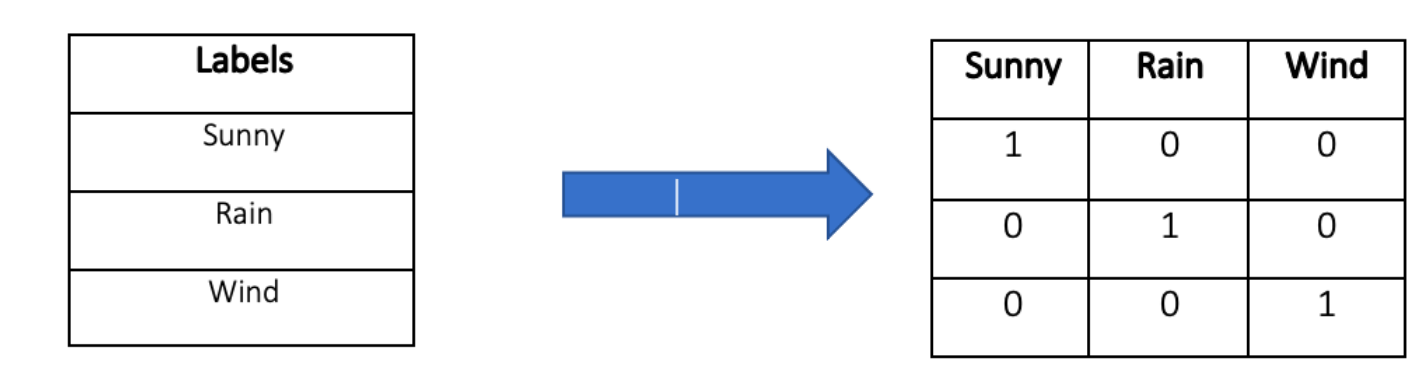

## Задание 5

Примени преобразования **One-Hot Encoding** для категориальных признаков. В этом тебе поможет функция [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Выведи размерность получившейся таблицы.

In [14]:
# Применяем One-Hot Encoding к категориальным признакам
X_cat_encoded = pd.get_dummies(X_cat)  
X_cat_encoded.shape

(32092, 24895)

## Задание 6

Теперь уже преобразованные части требуется снова объединить в единый датасет. Соедини переменные `X_num` и `X_cat` в переменную `X`. Воспользуйся методом [.merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html).
Объединение проведи по индексам таблицы.

Выведи размерность получившейся таблицы.

In [15]:
# Объединяем численные и категориальные признаки после кодирования
X = pd.merge(X_num, X_cat_encoded, on = ['client_id'])
X.shape

(32092, 28473)

## Разделение на Train и Test части

Разделение на тренировочную и тестовую части является важным шагом при обучении моделей машинного обучения. Этот процесс помогает оценить производительность модели на данных, которые она ранее не видела. Обычно данные разделяются в соотношении 70-80% на тренировочную выборку и 20-30% на тестовую выборку.

Разделение на тренировочную и тестовую части помогает избежать переобучения (overfitting) и оценить способность модели к обобщению на новые данные.

## Задание 7

Раздели итоговый датасет на train и test части. В этом тебе поможет функция [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Разделение проведи с параметрами `test_size=0.2`, `random_state=21`.

Выведи размерности переменных `X_train` и `X_test`.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Разделяем данные на обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

# Выводим размерности переменных X_train и X_test
print("Размерность X_train:", X_train.shape)
print("Размерность X_test:", X_test.shape)

Размерность X_train: (25673, 28473)
Размерность X_test: (6419, 28473)


## Обучение модели

Теперь у нас все готово для обучения!
Мы попробуем обучить модель на алгоритме градиентного бустинга. Градиентный бустинг — это метод машинного обучения, который используется для построения прогностических моделей, таких как регрессия или классификация. Он основан на идее построения ансамбля слабых моделей, обычно деревьев решений, и объединении их в сильную модель.

Теперь попробуй использовать алгоритм градиентного бустинга для обучения нашей модели предсказания оттока. Для этого примени алгоритм `CatBoostRegressor` из библиотеки `catboost`.

In [18]:
from catboost import CatBoostClassifier, MetricVisualizer
from sklearn.metrics import roc_auc_score, accuracy_score

In [19]:
model = CatBoostClassifier(iterations=1000, eval_metric='AUC', train_dir="base").fit(
    X_train,
    y_train,
    verbose=100,
    eval_set=(X_test, y_test),
)

Learning rate set to 0.07064
0:	test: 0.4822824	best: 0.4822824 (0)	total: 420ms	remaining: 6m 59s
100:	test: 0.6540517	best: 0.6547688 (98)	total: 20.7s	remaining: 3m 4s
200:	test: 0.6695957	best: 0.6697262 (198)	total: 40.9s	remaining: 2m 42s
300:	test: 0.6705090	best: 0.6705661 (214)	total: 1m	remaining: 2m 20s
400:	test: 0.6712805	best: 0.6715443 (393)	total: 1m 20s	remaining: 1m 59s
500:	test: 0.6734626	best: 0.6736611 (460)	total: 1m 39s	remaining: 1m 39s
600:	test: 0.6780993	best: 0.6781476 (564)	total: 1m 58s	remaining: 1m 18s
700:	test: 0.6805003	best: 0.6808436 (678)	total: 2m 18s	remaining: 59.1s
800:	test: 0.6820876	best: 0.6822704 (757)	total: 2m 37s	remaining: 39.2s
900:	test: 0.6820903	best: 0.6822704 (757)	total: 2m 57s	remaining: 19.5s
999:	test: 0.6811896	best: 0.6829080 (925)	total: 3m 16s	remaining: 0us

bestTest = 0.6829080443
bestIteration = 925

Shrink model to first 926 iterations.


## Задание 8

Рассчитай точность обученной модели. Для этого с помощью метода `.predict(X_test)` сделай предсказание на тестовой выборке `X_test`. Затем передай предсказанные классы и истинные значения оттока в функцию `accuracy_score`.

Не подозрительный ли получился результат? Рассчитай долю клиентов, которые **не уйдут**.

In [20]:
# Предсказания на тестовой выборке
Y_pred = model.predict(X_test)

# Рассчитываем точность
accuracy = accuracy_score(y_test, Y_pred)
print("Точность модели:", accuracy)

# Рассчитываем долю клиентов, которые не уйдут
staying_customers = (Y_pred == 0).mean()  
print("Доля клиентов, которые не уйдут:", staying_customers)

Точность модели: 0.9633899361271226
Доля клиентов, которые не уйдут: 0.9995326374824739


## Дисбаланс классов

При работе с несбалансированными классами использование метрики точности может привести к искаженным результатам оценки производительности модели. При дисбалансе классов модель может быть склонна чаще предсказывать наиболее представленный класс, что приведет к высокой точности для этого класса, но низкой для менее представленного класса. Точность может быть высокой, даже если модель предсказывает только доминирующий класс, игнорируя менее представленный класс. Это может создать ложное впечатление о качестве модели.

Для более информативной оценки модели в случае дисбаланса классов рекомендуется использовать другие метрики, такие как ROC AUC, F1-мера, точность и полнота. Эти метрики учитывают как правильность классификации положительных и отрицательных классов, так и способность модели находить все положительные случаи в данных.

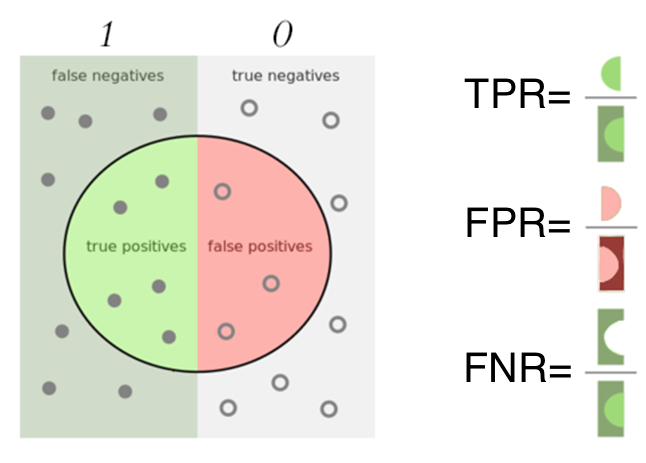

ROC AUC (Receiver Operating Characteristic Area Under the Curve) — это метрика, которая широко используется для оценки качества бинарной классификации моделей машинного обучения. Вот несколько причин, почему использовать ROC AUC полезно:

1. Интерпретируемость: ROC AUC предоставляет понятную интерпретацию качества классификационной модели. Значение ROC AUC находится между 0 и 1, где 1 означает идеальную модель, а 0.5 — модель, которая предсказывает случайно.

2. Устойчивость к дисбалансу классов: ROC AUC не зависит от дисбаланса классов в данных, что делает его хорошей метрикой для несбалансированных наборов данных.

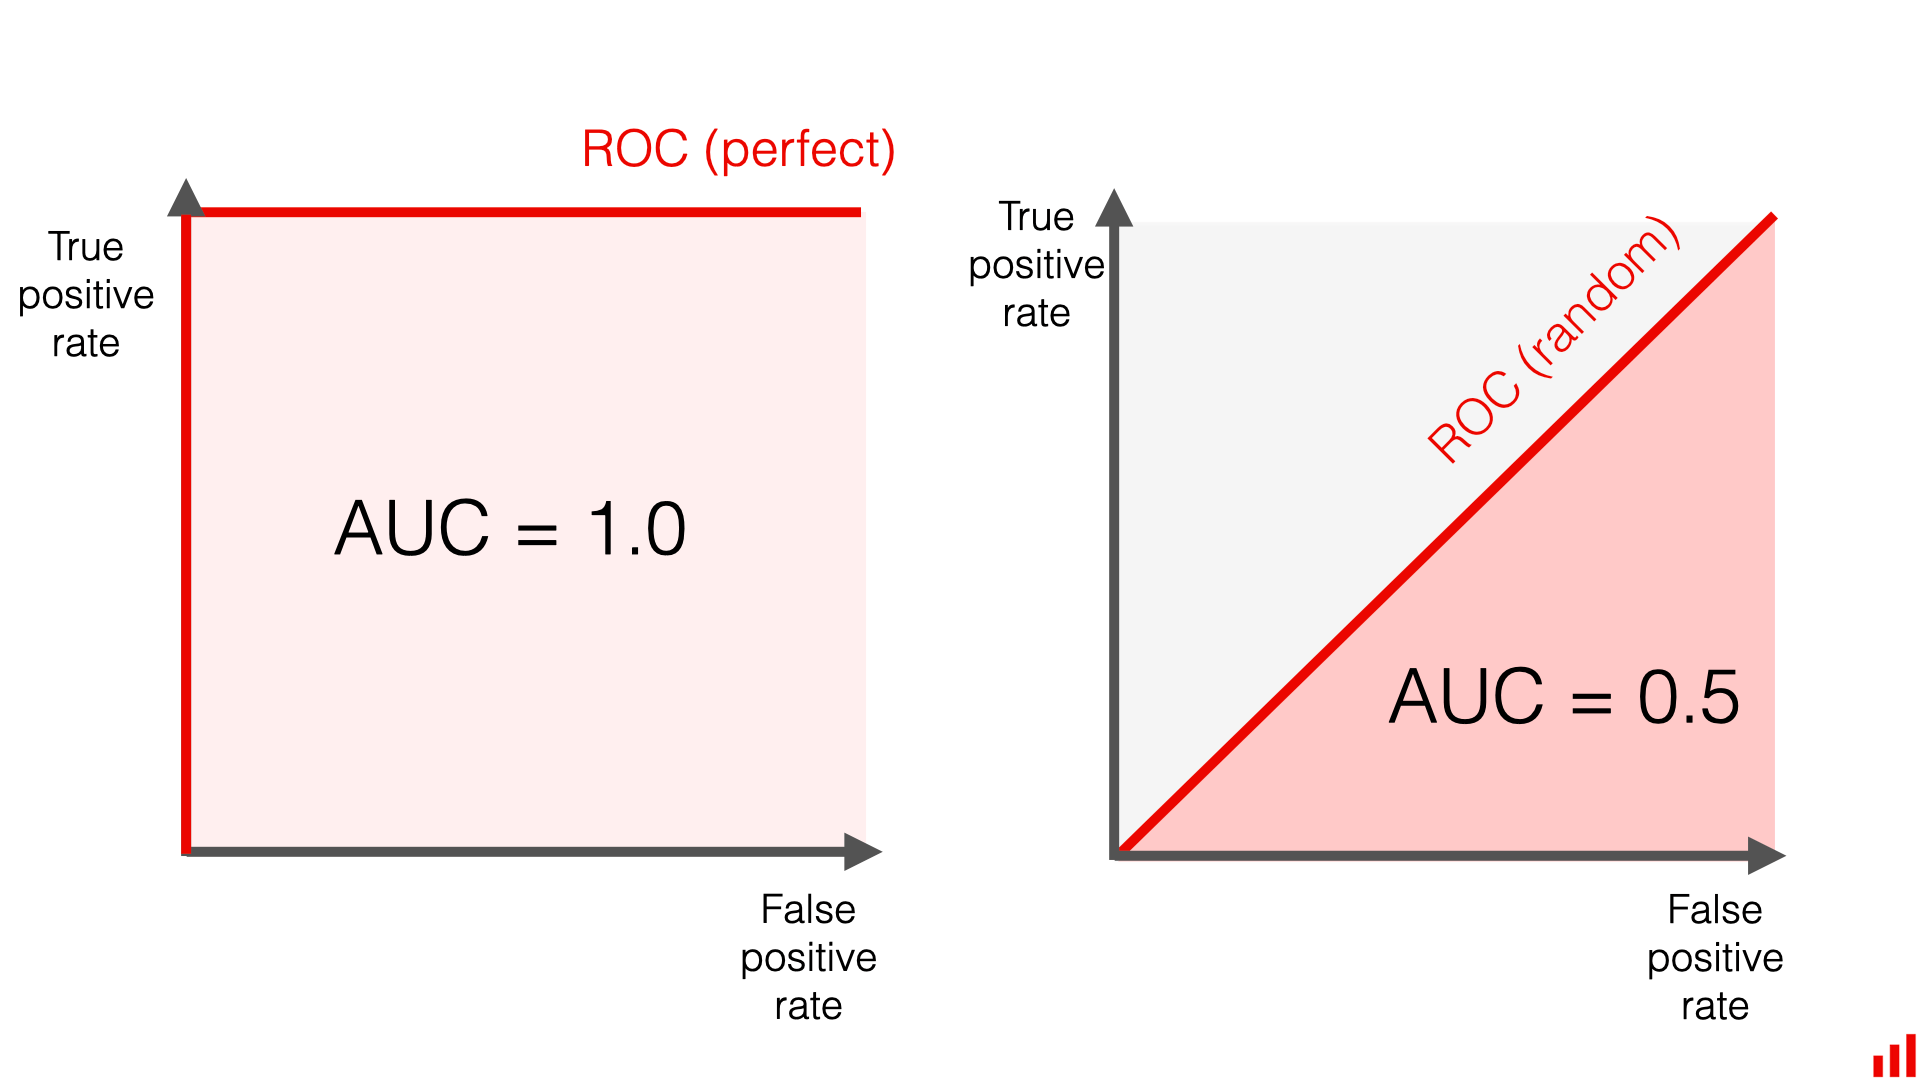

## Задание 9

Рассчитай метрику ROC-AUC. Для этого с помощью метода `.predict_proba(X_test)[:,1]` сделай предсказание на тестовой выборке `X_test`. Затем передай вероятности класса и истинные значения оттока в функцию `roc_auc_score`.

In [21]:
# Получение вероятностей для положительного класса
Y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности выхода в положительном классе

# Рассчет ROC-AUC
roc_auc = roc_auc_score(y_test, Y_pred_proba)
print("Метрика ROC-AUC:", roc_auc)

Метрика ROC-AUC: 0.6829080443049247


In [22]:
# from sklearn.metrics import f1_score


# # Рассчет F1-меры
# f1 = f1_score(y_test, Y_pred)
# print("Метрика F1:", f1)